In [18]:
import copy
import gc
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

from captum.attr import IntegratedGradients, Saliency, DeepLift, GradientShap, Lime, visualization
from matplotlib.patches import Rectangle
from os import path
from skimage import io
from skimage.segmentation import slic
from torch import optim
from torch.nn import functional as F
from torch.nn import Linear, CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import mnasnet0_5

## Generowanie wyjaśnień klasyfikacji dla zbioru *crop-and-weed-detection-data-with-bounding-boxes*

Przed uruchomieniem tego notebooka, należy zapewnić, że wcześniej uruchomiono notebook `Sesame_data_preparation.ipynb`. W nim dane pobierane są do odpowiednich katalogów oraz wykonywane jest wstępne przygotowanie danych. Dodatkowo, powinniśmy dysponować wytrenowanym modelem klasyfikującym. Aby taki model wygenerować, należy uruchomić notebook `Sesame_modeling.ipynb`. Poniżej można ustawić własne ścieżki.


In [2]:
input_dir = path.join('..', '..', 'input')
dataset = 'crop-and-weed-detection-data-with-bounding-boxes'
models_dir = path.join('..', 'models')
explanations_dir = path.join(input_dir, 'crop-and-weed-explanations')

if not path.exists(path.join(input_dir, dataset)):
     raise SystemExit("No dataset downloaded")
if not path.exists(path.join(input_dir, 'inz-data-prep', 'easy_labels_and_data.csv')):
     raise SystemExit("No data prepared")
if not path.exists(path.join(models_dir, 'mnasnet0_5')):
     raise SystemExit("No model parameters saved")

Flaga logiczna `GENERATE_EXPLANATIONS` określa czy w czasie uruchomienia notebook'a powinny być wygenerowane wyjaśnienia. Domyślnie zostaną wczytane z dysku z katalogu `explanations_dir`.

In [12]:
GENERATE_EXPLANATIONS = False

In [3]:
labels_frame = pd.read_csv(path.join(input_dir, 'inz-data-prep', 'easy_labels_and_data.csv'), index_col=0)

In [4]:
def show_image_bbox(image, bboxes: pd.DataFrame, ax=None):
    if ax is not None:
        ax.imshow(image)
    else:
        plt.imshow(image)
        ax = plt.gca()
    for idx, bbox in bboxes.iterrows():
        x = (bbox[0] - bbox[2] / 2) * 512
        y = (bbox[1] - bbox[3] / 2) * 512

        rect = Rectangle((x, y), bbox[2] * 512, bbox[3] * 512, fill=False, edgecolor='r')
        ax.add_patch(rect)
        
        
class CropWeedDataset(Dataset):
    
    def __init__(self, labels_csv, images_dir, transform=None):
        self.labels_frame = pd.read_csv(labels_csv, index_col=0)
        self.grouped_labels_frame = self.labels_frame.groupby('filename').sum("label")
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.grouped_labels_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = path.join(self.images_dir,
                                self.get_filename(idx))
        image = io.imread(img_name)
        label = int(self.grouped_labels_frame.iloc[idx, 0] > 0)
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def get_bbox(self, idx):
        bbox = self.labels_frame.loc[self.labels_frame['filename'] == self.grouped_labels_frame.iloc[idx].name].iloc[:,2:6]
        return bbox
    
    def get_filename(self, idx):
        return self.grouped_labels_frame.iloc[idx].name
    
    def show_image(self, idx, ax=None):
        sample = self[idx]
        bbox = self.get_bbox(idx)

        if self.transform:
            numpy_image = sample['image'].numpy().transpose(1, 2, 0)
        else:
            numpy_image = sample['image']

        show_image_bbox(numpy_image, bbox, ax)


    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image) / 255,
                'label': torch.asarray(label)}

In [5]:
dataset = CropWeedDataset(labels_csv=path.join(input_dir, 'inz-data-prep', 'easy_labels_and_data.csv'),
                          images_dir=path.join(input_dir, dataset, 'agri_data', 'data'),
                          transform=ToTensor())

In [6]:
train, test = random_split(dataset, [950, 204], generator=torch.Generator().manual_seed(420))
dataloaders = {'train':DataLoader(train, batch_size=8, shuffle=True, num_workers=2), 
               'val': DataLoader(test, batch_size=8, shuffle=True, num_workers=2)}
dataset_sizes = {'train': 950,
                'val': 204}


## Load model

In [8]:
model = mnasnet0_5()
model.classifier[1] = Linear(1280, 2)

In [9]:
model.load_state_dict(torch.load(path.join(models_dir, 'mnasnet0_5'), map_location=torch.device('cpu')))
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
F.softmax(model(torch.unsqueeze(dataset[0]['image'].to(device), 0)), dim=1)

tensor([[0.3631, 0.6369]], grad_fn=<SoftmaxBackward0>)

## Explanations

In [11]:
def lime_attr(sample):
    image = sample['image']
    label = sample['label']
    segment = slic(image.numpy().transpose(1,2,0), n_segments=70, compactness=16, start_label=0)
    attr = lime.attribute(torch.unsqueeze(image, 0).to(device), baselines, target=label, feature_mask=torch.from_numpy(segment).to(device))
    return attr

Poniższa komórka była uruchamiana wyłącznie w chmurze, gdy dostępna była akceleracja GPU. Uruchomienie lokalne może zająć dużo czasu.

In [ ]:
if GENERATE_EXPLANATIONS:
    ig_explanations = []
    saliency_explanations = []
    gradient_shap_explanations = []
    deeplift_explanations = []
    lime_explanations = []

    ig = IntegratedGradients(model)
    sal = Saliency(model)
    dl = DeepLift(model)
    gs = GradientShap(model)
    lime = Lime(model, interpretable_model=captum._utils.models.linear_model.SkLearnLasso(alpha=0.00))
    baselines = torch.rand(1, 3, 512, 512, device=device)

    for i, sample in enumerate(dataset):
        image = sample['image']
        label = sample['label']
        if i == 64:
            break
        ig_explanations += [ig.attribute(torch.unsqueeze(image,0).to(device), target=label, baselines=baselines)]
        saliency_explanations += [sal.attribute(torch.unsqueeze(image,0).to(device), target=label)]
        gradient_shap_explanations += [gs.attribute(torch.unsqueeze(image,0).to(device), target=label, baselines=baselines)]
        lime_explanations += [lime_attr(sample)]

    ig_tensor = torch.cat(ig_explanations)
    sal_tensor = torch.cat(saliency_explanations)
    gs_tensor = torch.cat(gradient_shap_explanations)
    lime_tensor = torch.cat(lime_explanations)

    torch.save(ig_tensor, path.join(explanations_dir, 'ig.pt'))
    torch.save(sal_tensor, path.join(explanations_dir, 'sal.pt'))
    torch.save(gs_tensor, path.join(explanations_dir, 'gs.pt'))
    torch.save(lime_tensor, path.join(explanations_dir, 'lime.pt'))

In [15]:
filenames = []
bboxes = []
for i, sample in enumerate(dataset):
        image = sample['image']
        label = sample['label']
        if i == 64:
            break
        filenames += [dataset.get_filename(i)]
        bboxes += [dataset.get_bbox(i)]
torch.save(filenames, path.join(explanations_dir, 'filenames.list'))
torch.save(bboxes, path.join(explanations_dir, 'bboxes.list'))

In [19]:
gc.collect()

1234

In [13]:
explanations = torch.stack([torch.load(path.join(explanations_dir, 'ig.pt'), map_location=torch.device(device)),
                            torch.load(path.join(explanations_dir, 'sal.pt'), map_location=torch.device(device)),
                            torch.load(path.join(explanations_dir, 'lime.pt'), map_location=torch.device(device))], 
                           dim=1)

In [9]:
explanations.shape

torch.Size([64, 3, 3, 512, 512])

In [10]:
def plot_image_and_explanations(idx):
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(14, 3*1))
    columns_names = ['Original', 'Gradients', 'Saliency', 'LIME']
    original_image = dataset[idx]['image'].cpu().numpy().transpose([1,2,0])
    for col, col_name in zip(ax, columns_names):
        col.title.set_text(col_name)
    ax[0].xaxis.set_ticks_position("none")
    ax[0].yaxis.set_ticks_position("none")
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[0].imshow(original_image, vmin=0, vmax=255)
    for j, col in enumerate(ax[1:]):
        #ith image, jth explanation
        #expl = explanations[i,j]
        expl = explanations[idx][j]
        sign = "all"
        cmap=None
        if expl.amin() >= 0:
            sign = "positive"
        _ = visualization.visualize_image_attr(np.transpose(expl.squeeze().cpu().numpy(), (1,2,0)),
                                     original_image=original_image,
                                     sign=sign,
                                     plt_fig_axis=(fig, col),
                                     show_colorbar=True,
                                     outlier_perc=2,
                                     cmap=cmap,
                                     use_pyplot=False,
                                     method='blended_heat_map' 
                                     )

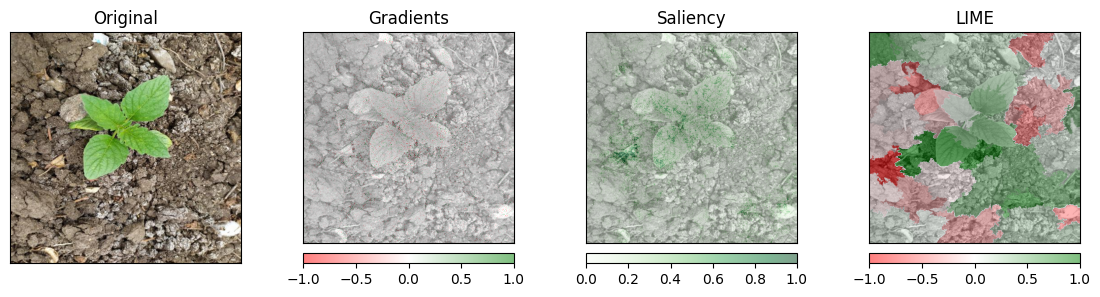

In [11]:
plot_image_and_explanations(5)

In [9]:
def to_numpy(tensor):
    return tensor.squeeze().cpu().numpy().transpose([1,2,0])

def bbox_to_mask(df, size=(512,512)):
    x_left = int(size[0] * (df.iloc[0]['x_cen'] - 0.5 * df.iloc[0]['w']))
    x_right = int(size[0] * (df.iloc[0]['x_cen'] + 0.5 * df.iloc[0]['w']))
    y_left = int(size[1] * (df.iloc[0]['y_cen'] - 0.5 * df.iloc[0]['h']))
    y_right = int(size[1] * (df.iloc[0]['y_cen'] + 0.5 * df.iloc[0]['h']))
    
    mask = torch.zeros(size)
    mask[y_left:y_right, x_left:x_right] = 1
    return mask

def normalize_0_1(x):
    return (x - x.min()) / (x.max() - x.min())

In [12]:
explanations_dict ={
    'Gradients': normalize_0_1(torch.load(path.join(explanations_dir, 'ig.pt'), map_location=torch.device('cpu'))),
    'Saliency': normalize_0_1(torch.load(path.join(explanations_dir, 'sal.pt'), map_location=torch.device('cpu'))),
    'Lime': normalize_0_1(torch.load(path.join(explanations_dir, 'lime.pt'), map_location=torch.device('cpu')))
}

In [13]:
predict = lambda x: torch.nn.Softmax(dim=1)(model(x))

In [14]:
original_data = torch.stack([dataset[i]['image'] for i in range(4)])

In [15]:
predict(original_data)

tensor([[0.3631, 0.6369],
        [0.2246, 0.7754],
        [0.3570, 0.6430],
        [0.3941, 0.6059]], grad_fn=<SoftmaxBackward0>)

In [10]:
bboxes = torch.load(path.join(explanations_dir, 'bboxes.list'))
filenames = torch.load(path.join(explanations_dir, 'filenames.list'))

In [19]:
masks = []
for i in range(64):
    masks += [bbox_to_mask(bboxes[i])]
    
masks = torch.stack(masks)

Metryki są liczone dla zdjęć w batchach po 4, aby mogło zadziałać lokalnie 

In [16]:
!mkdir {input_dir}/sesame_metrics

mkdir: cannot create directory ‘../../input/sesame_metrics’: File exists


In [24]:
def dict_to_matrix(original_data, explanations_dict, predictor, masks_tensor):
    for i in range(16):
        df = pd.DataFrame()
        data = torch.stack([dataset[4 * i + j]['image'] for j in range(4)])
        masks = masks_tensor[4 * i : 4 * (i + 1)] 
        for key, value in explanations_dict.items():
            value = value[4*i:4*(i+1)]
            for thresh in range(0, 10):
                thresh_val = thresh/10
                df.loc[key, f"DIR{thresh_val}"] = Metrics.decision_impact_ratio(data, predictor, value, thresh_val, 0)
                df.loc[key, f"CIR Same{thresh_val}"] = Metrics.confidence_impact_ratio(data, predictor, value, thresh_val, 0, compare_to="same_prediction")
                df.loc[key, f"CIR Max{thresh_val}"] = Metrics.confidence_impact_ratio(data, predictor, value, thresh_val, 0, compare_to="new_prediction")
                df.loc[key, f"Average Recall{thresh_val}"] = torch.mean(Metrics.accordance_recall(value, masks, thresh_val)).item()
                df.loc[key, f"Average Precision{thresh_val}"] = torch.mean(Metrics.accordance_precision(value, masks, thresh_val)).item()
                df.loc[key, f"F1_score{thresh_val}"] = Metrics.F1_score(value, masks, thresh_val)
                df.loc[key, f"IOU{thresh_val}"] = Metrics.intersection_over_union(value, masks, thresh_val)
            del value
        df.to_csv(path.join(input_dir, 'sesame_metrics', 'input_explanations_{i}.csv'.format(i=i))
        del masks
        del df

In [25]:
dict_to_matrix(original_data, explanations_dict, predict, masks)

In [32]:
df = pd.DataFrame()
for i in range(16):
    df = pd.concat([df,
                    pd.read_csv(path.join(input_dir, 
                                          'sesame_metrics', 
                                          'input_explanations_{i}.csv'.format(i=i)), index_col=0)
                   ], axis=0)

In [43]:
mean_df = df.groupby(by=df.index).mean()

Na podstawie poniższych metryk możemy wybrać wartosci thresholdów dla poszczególnych metod:
- Gradients 0.5
- Lime 0.4
- Saliency 0.1

In [45]:
mean_df.loc[:, ['DIR' in i for i in mean_df.columns]]

DIR0.0   DIR0.1   DIR0.2   DIR0.3    DIR0.4   DIR0.5  DIR0.6  \
Gradients  0.46875  0.46875  0.46875  0.46875  0.468750  0.46875     0.0   
Lime       0.46875  0.46875  0.46875  0.46875  0.171875  0.03125     0.0   
Saliency   0.46875  0.03125  0.00000  0.00000  0.000000  0.00000     0.0   

           DIR0.7  DIR0.8  DIR0.9  
Gradients     0.0     0.0     0.0  
Lime          0.0     0.0     0.0  
Saliency      0.0     0.0     0.0

In [57]:
mean_df.loc[:, ['CIR Same' in i for i in mean_df.columns]]

CIR Same0.0  CIR Same0.1  CIR Same0.2  CIR Same0.3  CIR Same0.4  \
Gradients     0.092362     0.092265     0.092190     0.091937     0.086534   
Lime          0.092362     0.093056     0.094592     0.081158     0.031171   
Saliency      0.092362    -0.003744    -0.000977    -0.000085     0.000017   

           CIR Same0.5  CIR Same0.6  CIR Same0.7  CIR Same0.8  CIR Same0.9  
Gradients     0.079943     0.002168     0.000122     0.000022    -0.000018  
Lime          0.006921     0.002823     0.001969     0.000689     0.000689  
Saliency     -0.000003    -0.000065     0.000010     0.000006    -0.000031

In [47]:
mean_df.loc[:, ['CIR Max' in i for i in mean_df.columns]]

CIR Max0.0  CIR Max0.1  CIR Max0.2  CIR Max0.3  CIR Max0.4  \
Gradients   -0.049253   -0.049350   -0.049425   -0.049678   -0.056477   
Lime        -0.049253   -0.048559   -0.045574   -0.019635    0.024843   
Saliency    -0.049253   -0.004257   -0.000977   -0.000085    0.000017   

           CIR Max0.5  CIR Max0.6  CIR Max0.7  CIR Max0.8  CIR Max0.9  
Gradients   -0.100693    0.002168    0.000122    0.000022   -0.000018  
Lime         0.006585    0.002823    0.001969    0.000689    0.000689  
Saliency    -0.000003   -0.000065    0.000010    0.000006   -0.000031

In [48]:
mean_df.loc[:, ['Recall' in i for i in mean_df.columns]]

Average Recall0.0  Average Recall0.1  Average Recall0.2  \
Gradients                1.0           1.000000           1.000000   
Lime                     1.0           0.997650           0.983332   
Saliency                 1.0           0.013476           0.001608   

           Average Recall0.3  Average Recall0.4  Average Recall0.5  \
Gradients           0.999998           0.999973           0.981419   
Lime                0.870542           0.297337           0.067000   
Saliency            0.000293           0.000064           0.000019   

           Average Recall0.6  Average Recall0.7  Average Recall0.8  \
Gradients           0.000144           0.000003       6.162508e-07   
Lime                0.016359           0.006180       2.013803e-03   
Saliency            0.000005           0.000002       6.670312e-07   

           Average Recall0.9  
Gradients       2.742498e-08  
Lime            2.013803e-03  
Saliency        2.482483e-07

In [49]:
mean_df.loc[:, ['Precision' in i for i in mean_df.columns]]

Average Precision0.0  Average Precision0.1  Average Precision0.2  \
Gradients              0.549989              0.549989              0.549989   
Lime                   0.550162              0.550700              0.551444   
Saliency               0.549989              0.790011              0.544348   

           Average Precision0.3  Average Precision0.4  Average Precision0.5  \
Gradients              0.549988              0.549984              0.547502   
Lime                   0.550225              0.566723              0.285080   
Saliency               0.413712              0.329866              0.235439   

           Average Precision0.6  Average Precision0.7  Average Precision0.8  \
Gradients              0.893141              0.141506              0.031250   
Lime                   0.118143              0.076396              0.014078   
Saliency               0.156250              0.062500              0.062500   

           Average Precision0.9  
Gradients              0.015625  
Lime                   0.014078  
Saliency               0.062500

In [50]:
mean_df.loc[:, ['F1' in i for i in mean_df.columns]]

F1_score0.0  F1_score0.1  F1_score0.2  F1_score0.3  F1_score0.4  \
Gradients     0.677500     0.677500     0.677500     0.677499     0.677489   
Lime          0.677637     0.677360     0.674869     0.644186     0.308178   
Saliency      0.677500     0.024407     0.000412     0.000029     0.000000   

           F1_score0.5  F1_score0.6  F1_score0.7  F1_score0.8  F1_score0.9  
Gradients     0.671101     0.000288          0.0          0.0          0.0  
Lime          0.021101     0.000000          0.0          0.0          0.0  
Saliency      0.000000     0.000000          0.0          0.0          0.0

In [51]:
mean_df.loc[:, ['IOU' in i for i in mean_df.columns]]

IOU0.0    IOU0.1    IOU0.2    IOU0.3    IOU0.4    IOU0.5  \
Gradients  0.549989  0.549989  0.549989  0.549987  0.549974  0.542200   
Lime       0.550162  0.549615  0.546885  0.508115  0.205536  0.055831   
Saliency   0.549989  0.012868  0.001600  0.000292  0.000064  0.000019   

             IOU0.6    IOU0.7        IOU0.8        IOU0.9  
Gradients  0.000144  0.000003  6.162508e-07  2.742498e-08  
Lime       0.015243  0.006147  1.985684e-03  1.985684e-03  
Saliency   0.000005  0.000002  6.670312e-07  2.482483e-07

Następnie policzymy metryki, które będą używane w agregacji autoweighted. Tu należy już ewaluować każde zdjęcie osobno, potrzebujemy oceny każdego zdjęcia.

In [68]:
def calculate_metrics(original_data, explanations_dict, predictor):
    df_all = pd.DataFrame()
    for i in range(64):
        df = pd.DataFrame()
        data = dataset[i]['image'].unsqueeze(0)
        for key, value in explanations_dict.items():
            value = value[i].unsqueeze(0)
            for thresh in range(0, 10):
                thresh_val = thresh/10
                df.loc[key, f"DIR{thresh_val}"] = Metrics.decision_impact_ratio(data, predictor, value, thresh_val, 0)
                df.loc[key, f"CIR Same{thresh_val}"] = Metrics.confidence_impact_ratio(data, predictor, value, thresh_val, 0, compare_to="same_prediction")
                df.loc[key, f"CIR Max{thresh_val}"] = Metrics.confidence_impact_ratio(data, predictor, value, thresh_val, 0, compare_to="new_prediction")
            del value
        df_all = pd.concat([df_all, df], axis=0)
    return df_all

In [69]:
sample_metrics = calculate_metrics(original_data, explanations_dict, predict)
sample_metrics['sample_number'] = [i//3 for i in range(192)]

DIR0.0  CIR Same0.0  CIR Max0.0  DIR0.1  CIR Same0.1  CIR Max0.1  \
Gradients     0.0    -0.014205   -0.014205     0.0    -0.014205   -0.014205   
Saliency      0.0    -0.014205   -0.014205     0.0    -0.034844   -0.034844   
Lime          0.0    -0.014205   -0.014205     0.0    -0.004415   -0.004415   
Gradients     0.0     0.124315    0.124315     0.0     0.118140    0.118140   
Saliency      0.0     0.124315    0.124315     0.0    -0.047002   -0.047002   
...           ...          ...         ...     ...          ...         ...   
Saliency      1.0     0.232948   -0.069164     0.0    -0.001722   -0.001722   
Lime          1.0     0.232948   -0.069164     1.0     0.232948   -0.069164   
Gradients     0.0     0.023860    0.023860     0.0     0.023860    0.023860   
Saliency      0.0     0.023860    0.023860     0.0    -0.047711   -0.047711   
Lime          0.0     0.023860    0.023860     0.0     0.023860    0.023860   

           DIR0.2  CIR Same0.2  CIR Max0.2  DIR0.3  ...  CIR Max0.6  DIR0.7  \
Gradients     0.0    -0.014205   -0.014205     0.0  ...    0.000895     0.0   
Saliency      0.0    -0.003255   -0.003255     0.0  ...    0.000000     0.0   
Lime          0.0    -0.010040   -0.010040     0.0  ...    0.017684     0.0   
Gradients     0.0     0.113410    0.113410     0.0  ...    0.012802     0.0   
Saliency      0.0    -0.045060   -0.045060     0.0  ...   -0.011191     0.0   
...           ...          ...         ...     ...  ...         ...     ...   
Saliency      0.0     0.000000    0.000000     0.0  ...    0.000000     0.0   
Lime          1.0     0.232948   -0.069164     1.0  ...    0.000000     0.0   
Gradients     0.0     0.023860    0.023860     0.0  ...    0.016618     0.0   
Saliency      0.0    -0.003560   -0.003560     0.0  ...    0.000000     0.0   
Lime          0.0     0.023860    0.023860     0.0  ...   -0.001124     0.0   

           CIR Same0.7  CIR Max0.7  DIR0.8  CIR Same0.8  CIR Max0.8  DIR0.9  \
Gradients     0.000000    0.000000     0.0     0.000000    0.000000     0.0   
Saliency      0.000000    0.000000     0.0     0.000000    0.000000     0.0   
Lime         -0.008687   -0.008687     0.0     0.000000    0.000000     0.0   
Gradients     0.003389    0.003389     0.0     0.000665    0.000665     0.0   
Saliency     -0.000467   -0.000467     0.0    -0.001269   -0.001269     0.0   
...                ...         ...     ...          ...         ...     ...   
Saliency      0.000000    0.000000     0.0     0.000000    0.000000     0.0   
Lime          0.000000    0.000000     0.0     0.000000    0.000000     0.0   
Gradients     0.000000    0.000000     0.0     0.000000    0.000000     0.0   
Saliency      0.000000    0.000000     0.0     0.000000    0.000000     0.0   
Lime          0.000000    0.000000     0.0     0.000000    0.000000     0.0   

           CIR Same0.9  CIR Max0.9  
Gradients     0.000000    0.000000  
Saliency      0.000000    0.000000  
Lime          0.000000    0.000000  
Gradients    -0.001128   -0.001128  
Saliency     -0.000190   -0.000190  
...                ...         ...  
Saliency      0.000000    0.000000  
Lime          0.000000    0.000000  
Gradients     0.000000    0.000000  
Saliency      0.000000    0.000000  
Lime          0.000000    0.000000  

[192 rows x 30 columns]

In [101]:
sample_metrics.to_csv(path.join(input_dir, 'sesame_metrics', 'input_sample_explanations.csv'))

In [9]:
sample_metrics = pd.read_csv(path.join(input_dir, 'sesame_metrics', 'input_sample_explanations.csv'), index_col=0)

In [10]:
sample_metrics

DIR0.0  CIR Same0.0  CIR Max0.0  DIR0.1  CIR Same0.1  CIR Max0.1  \
Gradients     0.0    -0.014205   -0.014205     0.0    -0.014205   -0.014205   
Saliency      0.0    -0.014205   -0.014205     0.0    -0.034844   -0.034844   
Lime          0.0    -0.014205   -0.014205     0.0    -0.004415   -0.004415   
Gradients     0.0     0.124315    0.124315     0.0     0.118140    0.118140   
Saliency      0.0     0.124315    0.124315     0.0    -0.047002   -0.047002   
...           ...          ...         ...     ...          ...         ...   
Saliency      1.0     0.232948   -0.069164     0.0    -0.001722   -0.001722   
Lime          1.0     0.232948   -0.069164     1.0     0.232948   -0.069164   
Gradients     0.0     0.023860    0.023860     0.0     0.023860    0.023860   
Saliency      0.0     0.023860    0.023860     0.0    -0.047711   -0.047711   
Lime          0.0     0.023860    0.023860     0.0     0.023860    0.023860   

           DIR0.2  CIR Same0.2  CIR Max0.2  DIR0.3  ...  DIR0.7  CIR Same0.7  \
Gradients     0.0    -0.014205   -0.014205     0.0  ...     0.0     0.000000   
Saliency      0.0    -0.003255   -0.003255     0.0  ...     0.0     0.000000   
Lime          0.0    -0.010040   -0.010040     0.0  ...     0.0    -0.008687   
Gradients     0.0     0.113410    0.113410     0.0  ...     0.0     0.003389   
Saliency      0.0    -0.045060   -0.045060     0.0  ...     0.0    -0.000467   
...           ...          ...         ...     ...  ...     ...          ...   
Saliency      0.0     0.000000    0.000000     0.0  ...     0.0     0.000000   
Lime          1.0     0.232948   -0.069164     1.0  ...     0.0     0.000000   
Gradients     0.0     0.023860    0.023860     0.0  ...     0.0     0.000000   
Saliency      0.0    -0.003560   -0.003560     0.0  ...     0.0     0.000000   
Lime          0.0     0.023860    0.023860     0.0  ...     0.0     0.000000   

           CIR Max0.7  DIR0.8  CIR Same0.8  CIR Max0.8  DIR0.9  CIR Same0.9  \
Gradients    0.000000     0.0     0.000000    0.000000     0.0     0.000000   
Saliency     0.000000     0.0     0.000000    0.000000     0.0     0.000000   
Lime        -0.008687     0.0     0.000000    0.000000     0.0     0.000000   
Gradients    0.003389     0.0     0.000665    0.000665     0.0    -0.001128   
Saliency    -0.000467     0.0    -0.001269   -0.001269     0.0    -0.000190   
...               ...     ...          ...         ...     ...          ...   
Saliency     0.000000     0.0     0.000000    0.000000     0.0     0.000000   
Lime         0.000000     0.0     0.000000    0.000000     0.0     0.000000   
Gradients    0.000000     0.0     0.000000    0.000000     0.0     0.000000   
Saliency     0.000000     0.0     0.000000    0.000000     0.0     0.000000   
Lime         0.000000     0.0     0.000000    0.000000     0.0     0.000000   

           CIR Max0.9  sample_number  
Gradients    0.000000              0  
Saliency     0.000000              0  
Lime         0.000000              0  
Gradients   -0.001128              1  
Saliency    -0.000190              1  
...               ...            ...  
Saliency     0.000000             62  
Lime         0.000000             62  
Gradients    0.000000             63  
Saliency     0.000000             63  
Lime         0.000000             63  

[192 rows x 31 columns]

Z ramki metryk dla obserwacji wybieramy kolumny o danym thresholdzie.

In [11]:
precomputed_metrics = np.stack([
                                sample_metrics.loc['Gradients', ['0.5' in i for i in sample_metrics.columns]].to_numpy(),
                                sample_metrics.loc['Lime', ['0.4' in i for i in sample_metrics.columns]].to_numpy(),
                                sample_metrics.loc['Saliency', ['0.1' in i for i in sample_metrics.columns]].to_numpy()
                            ]).transpose([1, 0, 2])
precomputed_metrics = torch.from_numpy(precomputed_metrics)

In [12]:
precomputed_metrics.shape

torch.Size([64, 3, 3])

## Agregacja

In [12]:
import sys
 
# setting path
sys.path.append('..')
 
from EnsembleXAI import Metrics
# importing
from EnsembleXAI.Metrics import consistency, stability
from EnsembleXAI.Ensemble import basic, autoweighted, supervisedXAI, _normalize_across_dataset


### autoweighted

In [15]:
import gc
gc.collect()

0

In [15]:
metric_weights = [0.1, 0.6, 0.3]

In [16]:
agg = autoweighted(inputs=explanations.transpose(2, 1),
                   metric_weights=metric_weights, 
                   precomputed_metrics=precomputed_metrics)

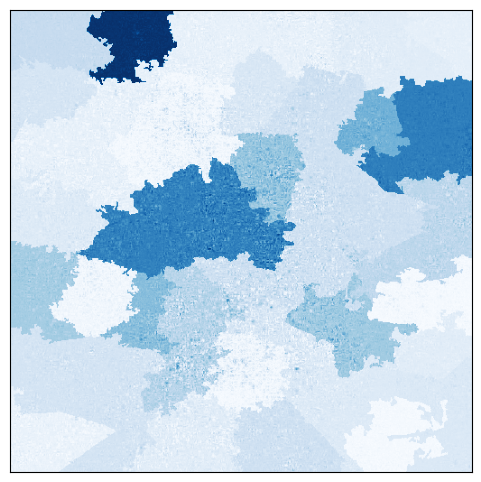

(<Figure size 600x600 with 1 Axes>, <AxesSubplot: >)

In [17]:
aggregated_sample = agg[8]
visualization.visualize_image_attr(aggregated_sample.squeeze().cpu().numpy().transpose([1,2,0]))

In [18]:
torch.save(agg, path.join(explanations_dir, 'autoweighted.pt'))

### basic

In [16]:
if False:
    agg = basic(explanations, 'avg')
    torch.save(agg, path.join(explanations_dir, 'avg.pt'))
else:
    agg = torch.load(path.join(explanations_dir, 'avg.pt'), map_location=torch.device('cpu'))

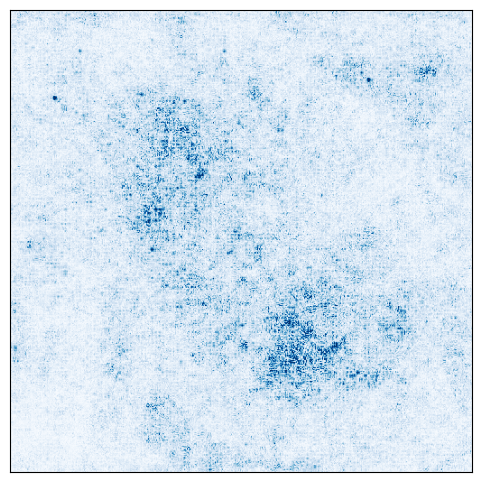

(<Figure size 600x600 with 1 Axes>, <AxesSubplot: >)

In [17]:
aggregated_sample = agg[0]
visualization.visualize_image_attr(aggregated_sample.squeeze().cpu().numpy().transpose([1,2,0]))

### supervisedXAI

In [ ]:
krr_exp = supervisedXAI(explanations, masks, weights='auto')

In [14]:
krr_exp_no_weights = supervisedXAI(explanations, masks)

In [18]:
torch.save(krr_exp, path.join(explanations_dir, 'supervised.pt'))

In [15]:
torch.save(krr_exp_no_weights, path.join(explanations_dir, 'supervised_no_weights.pt'))

Sprawdzenie, że supervisedXAI daje różne, ale podobne wyniki

In [25]:
(krr_exp[2, 186, 213], krr_exp[0, 186, 213])

(tensor(0.8038, dtype=torch.float64), tensor(0.8040, dtype=torch.float64))

In [22]:
def show_explanations(idx, image_dir=path.join('..', '..', 'input', 
                      'crop-and-weed-detection-data-with-bounding-boxes' , 
                      'agri_data', 'data')):
    image = io.imread(path.join(image_dir, filenames[idx]))
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 6))
    
    dataset.show_image(idx, ax1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("original")
    

    #integrated gradients
    visualization.visualize_image_attr(to_numpy(explanations[idx, 0]),
                                       original_image=image,
                                       plt_fig_axis=(fig, ax2),
                                       method='blended_heat_map',
                                       use_pyplot=False,
                                       title='integrated gradients')
    visualization.visualize_image_attr(to_numpy(explanations[idx, 2]),
                                       original_image=image,
                                       plt_fig_axis=(fig, ax3),
                                       method='blended_heat_map',
                                       use_pyplot=False,
                                       title='lime')

    visualization.visualize_image_attr(to_numpy(explanations[idx, 1]),
                                       original_image=image,
                                       plt_fig_axis=(fig, ax4),
                                       method='blended_heat_map',
                                       use_pyplot=False,
                                       title='saliency')

    visualization.visualize_image_attr(to_numpy(torch.stack([krr_exp[idx]]*3, dim=0)),
                                       original_image=image,
                                       plt_fig_axis=(fig, ax5),
                                       method='blended_heat_map',
                                       use_pyplot=False,
                                       title='krr ensembleXAI')

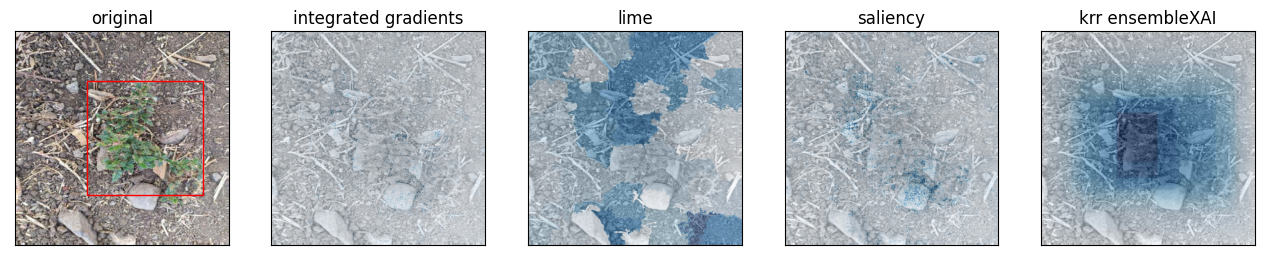

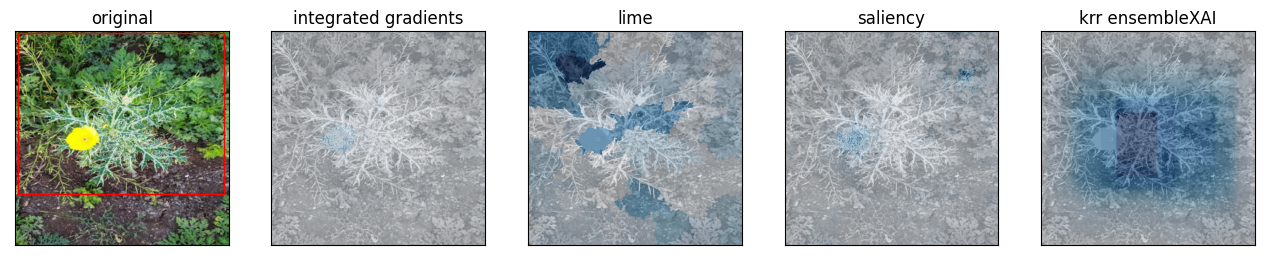

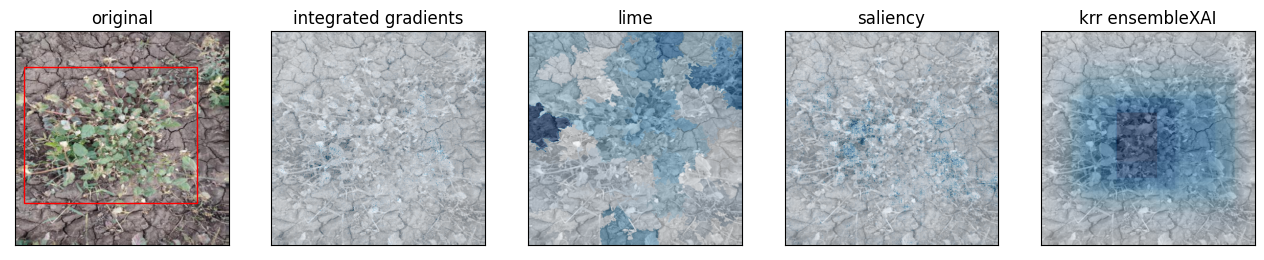

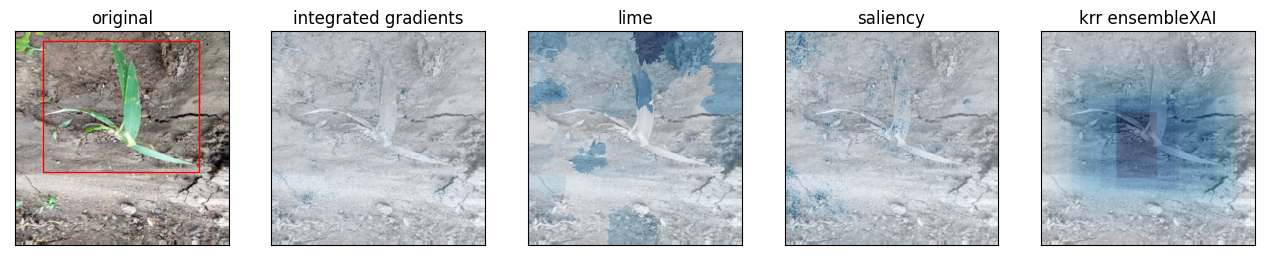

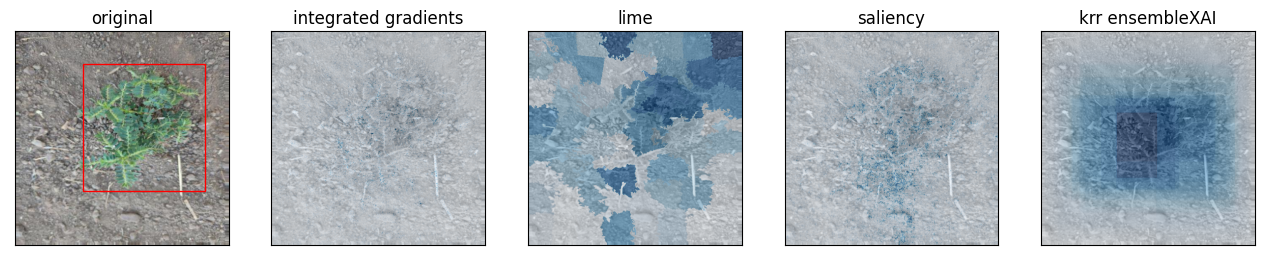

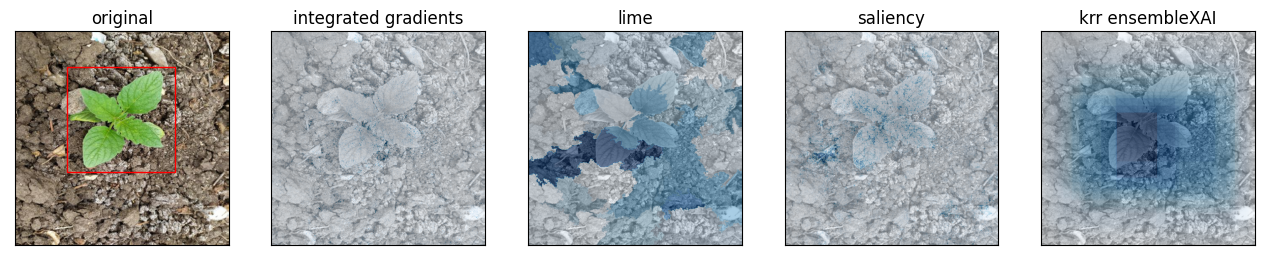

In [23]:
for i in range(6):
    show_explanations(i)

In [34]:
plt.close("all")